The code in this notebook is based on the [Keras documentation](https://keras.io/) and [blog](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) as well as this [word2vec tutorial](http://adventuresinmachinelearning.com/gensim-word2vec-tutorial/).   

In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import time

os.environ['KERAS_BACKEND']='cntk'
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import History, CSVLogger
from keras.utils import to_categorical

Using CNTK backend


Download the Amazon reviews data for food from the Internet archive 
[J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013]

In [12]:
!wget "https://archive.org/download/amazon-reviews-1995-2013/Gourmet_Foods.txt.gz"

--2017-09-21 15:00:07--  https://archive.org/download/amazon-reviews-1995-2013/Gourmet_Foods.txt.gz
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://ia801306.us.archive.org/24/items/amazon-reviews-1995-2013/Gourmet_Foods.txt.gz [following]
--2017-09-21 15:00:07--  https://ia801306.us.archive.org/24/items/amazon-reviews-1995-2013/Gourmet_Foods.txt.gz
Resolving ia801306.us.archive.org (ia801306.us.archive.org)... 207.241.228.136
Connecting to ia801306.us.archive.org (ia801306.us.archive.org)|207.241.228.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31388180 (30M) [application/octet-stream]
Saving to: ‘Gourmet_Foods.txt.gz’

Gourmet_Foods.txt.g 100%[===================>]  29.93M   186KB/s    in 77s     

2017-09-21 15:01:25 (397 KB/s) - ‘Gourmet_Foods.txt.gz’ saved [31388180/31388180]



In [13]:
!gunzip -f Gourmet_Foods.txt.gz

In [17]:
with open("Gourmet_Foods.txt", "r") as fp:
    lst = fp.readlines()

Extract scores and review texts from file 

In [60]:
text_lst = lst[9:len(lst):11]
score_lst = lst[6:len(lst):11]
score_lst2 = [sc[14:17] for sc in score_lst]
text_lst2 = [txt[13:] for txt in text_lst]

In [74]:
all_data = pd.DataFrame(data={'text': text_lst2, 'rating': score_lst2})
all_data.loc[:, 'rating'] = all_data['rating'].astype(float)
all_data.loc[:, 'rating'] = all_data['rating'].astype(int)

Remove medium rating and convert to binary classification (high vs. low rating).  

In [80]:
all_data = all_data[all_data['rating'] != 3]

In [88]:
new_data = all_data.replace({'rating': {1: '0', 2: '0', 4: '1', 5: '1'}})
new_data.loc[:, 'rating'] = new_data['rating'].astype(int)

Extract a balanced subsample and split into training and test sets.

In [116]:
sample_data = pd.concat([new_data[new_data.rating == 0].sample(10000), new_data[new_data.rating == 1].sample(10000)])
shuffled = sample_data.iloc[np.random.permutation(20000), :]
train_data = shuffled.iloc[:10000, :]
test_data = shuffled.iloc[10000:, :]

In [124]:
train_data.rating.value_counts()

1    5005
0    4995
Name: rating, dtype: int64

In [118]:
test_data.rating.value_counts()

0    5005
1    4995
Name: rating, dtype: int64

Set the dimensions of the input and the embedding. 

MAX_DOC_LENGTH : the size of the input i.e. the number of words in the document. Longer documents will be truncated, shorter ones will be padded with zeros.

VOCAB_SIZE : the size of the word encoding (number of most frequent words to keep in the vocabulary)

EMBEDDING_DIM : the dimensionality of the word embedding

In [125]:
MAX_DOC_LEN = 300
VOCAB_SIZE = 6000
EMBEDDING_DIM = 100

In [126]:
TEXT_COL = 'text'
LABEL_COL = 'rating'

Fit a Keras tokenizer to the most frequent words using the entire training data set as the corpus.

In [127]:
# tokenize, create seqs, pad
tok = Tokenizer(num_words=VOCAB_SIZE, lower=True, split=" ")
tok.fit_on_texts(train_data[TEXT_COL])
train_seq = tok.texts_to_sequences(train_data[TEXT_COL])
train_seq = sequence.pad_sequences(train_seq, maxlen=MAX_DOC_LEN)
test_seq = tok.texts_to_sequences(test_data[TEXT_COL])
test_seq = sequence.pad_sequences(test_seq, maxlen=MAX_DOC_LEN)

Convert the ratings to one-hot categorical labels.

In [128]:
labels = to_categorical(np.asarray(train_data[LABEL_COL]))
labels = labels.astype('float32')

In [129]:
print('Number of reviews by class in training set')
print(labels.sum(axis=0))
n_classes = labels.shape[1]

Number of reviews by class in training set
[ 4995.  5005.]


Train word2vec on all the documents in order to initialize the word embedding. Ignore rare words (min_count=6). Use skip-gram as the training algorithm (sg=1).

In [130]:
import nltk 

nltk.download('punkt')

sent_lst = []

for doc in train_data[TEXT_COL]:
    sentences = nltk.tokenize.sent_tokenize(doc)
    for sent in sentences:
        word_lst = [w for w in nltk.tokenize.word_tokenize(sent) if w.isalnum()]
        sent_lst.append(word_lst)

[nltk_data] Downloading package punkt to /home/anargyri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [131]:
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# use skip-gram
word2vec_model = gensim.models.Word2Vec(sentences=sent_lst, min_count=6, size=EMBEDDING_DIM, sg=1, workers=os.cpu_count())

2017-09-21 16:29:01,720 : INFO : collecting all words and their counts
2017-09-21 16:29:01,721 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-09-21 16:29:01,761 : INFO : PROGRESS: at sentence #10000, processed 151224 words, keeping 11866 word types
2017-09-21 16:29:01,800 : INFO : PROGRESS: at sentence #20000, processed 300037 words, keeping 17003 word types
2017-09-21 16:29:01,843 : INFO : PROGRESS: at sentence #30000, processed 453236 words, keeping 21102 word types
2017-09-21 16:29:01,890 : INFO : PROGRESS: at sentence #40000, processed 606597 words, keeping 24141 word types
2017-09-21 16:29:01,919 : INFO : collected 26181 word types from a corpus of 712241 raw words and 47144 sentences
2017-09-21 16:29:01,921 : INFO : Loading a fresh vocabulary
2017-09-21 16:29:01,952 : INFO : min_count=6 retains 6289 unique words (24% of original 26181, drops 19892)
2017-09-21 16:29:01,953 : INFO : min_count=6 leaves 678196 word corpus (95% of original 712241, drop

Create the initial embedding matrix from the output of word2vec.

In [132]:
embeddings_index = {}

for word in word2vec_model.wv.vocab:
    coefs = np.asarray(word2vec_model.wv[word], dtype='float32')
    embeddings_index[word] = coefs

print('Total %s word vectors.' % len(embeddings_index))

# Initial embedding
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < VOCAB_SIZE:
        embedding_matrix[i] = embedding_vector

Total 6289 word vectors.


LSTM_DIM is the dimensionality of each LSTM output (the number of LSTM units).
The mask_zero option determines whether masking is performed, i.e. whether the layers ignore the padded zeros in shorter documents. CNTK / Keras does not support masking yet.

In [136]:
BATCH_SIZE = 50
NUM_EPOCHS = 30
LSTM_DIM = 100
OPTIMIZER = SGD(lr=0.01, nesterov=True)

In [142]:
def lstm_create_train(reg_param):
    l2_reg = regularizers.l2(reg_param)

    # model init
    embedding_layer = Embedding(VOCAB_SIZE,
                                EMBEDDING_DIM,
                                input_length=MAX_DOC_LEN,
                                trainable=True,
                                mask_zero=False,
                                embeddings_regularizer=l2_reg,
                                weights=[embedding_matrix])

    lstm_layer = LSTM(units=LSTM_DIM, kernel_regularizer=l2_reg)
    dense_layer = Dense(n_classes, activation='softmax', kernel_regularizer=l2_reg)

    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(lstm_layer))
    model.add(dense_layer)

    model.compile(loss='categorical_crossentropy',
                  optimizer=OPTIMIZER,
                  metrics=['acc'])

    fname = "lstm_food"
    history = History()
    csv_logger = CSVLogger('./{0}_{1}.log'.format(fname, reg_param),
                           separator=',',
                           append=True)

    t1 = time.time()
    # model fit
    model.fit(train_seq,
              labels.astype('float32'),
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              callbacks=[history, csv_logger],
              verbose=2)
    t2 = time.time()

    # save model
    model.save('./{0}_{1}_model.h5'.format(fname, reg_param))
    np.savetxt('./{0}_{1}_time.txt'.format(fname, reg_param), 
               [reg_param, (t2-t1) / 3600])
    with open('./{0}_{1}_history.txt'.format(fname, reg_param), "w") as res_file:
        res_file.write(str(history.history))

In [151]:
lstm_create_train(1e-7)

Epoch 1/15
76s - loss: 0.6882 - acc: 0.5696
Epoch 2/15
75s - loss: 0.6825 - acc: 0.6040
Epoch 3/15
75s - loss: 0.6768 - acc: 0.6188
Epoch 4/15
75s - loss: 0.6705 - acc: 0.6373
Epoch 5/15
74s - loss: 0.6633 - acc: 0.6426
Epoch 6/15
75s - loss: 0.6543 - acc: 0.6563
Epoch 7/15
74s - loss: 0.6412 - acc: 0.6653
Epoch 8/15
74s - loss: 0.6125 - acc: 0.6884
Epoch 9/15
74s - loss: 0.5350 - acc: 0.7356
Epoch 10/15
75s - loss: 0.5045 - acc: 0.7573
Epoch 11/15
75s - loss: 0.4971 - acc: 0.7684
Epoch 12/15
75s - loss: 0.4850 - acc: 0.7749
Epoch 13/15
75s - loss: 0.4825 - acc: 0.7734
Epoch 14/15
74s - loss: 0.4708 - acc: 0.7800
Epoch 15/15
74s - loss: 0.4700 - acc: 0.7798


In [152]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

model = load_model('./lstm_food_{0}_model.h5'.format(1e-7))
preds = model.predict(test_seq, verbose=0)
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(test_data[LABEL_COL], preds.argmax(axis=1)), 
       roc_auc_score(test_data[LABEL_COL], preds[:, 1]))))

Accuracy = 0.8023 	 AUC = 0.8845375045375046


In [153]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


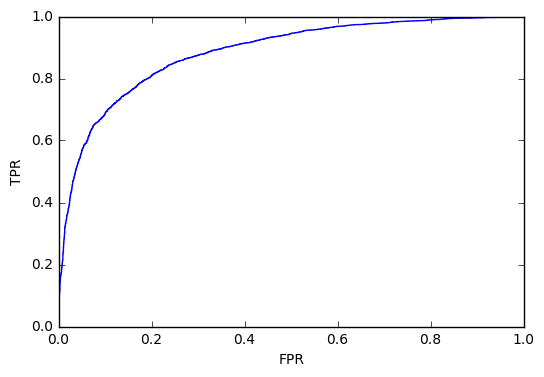

In [155]:
fpr, tpr, _ = roc_curve(test_data[LABEL_COL], preds[:, 1])
plot(fpr, tpr)
xlabel('FPR')
ylabel('TPR')